<a href="https://colab.research.google.com/github/dbrody112/An-Automatic-Thresholding-Algorithm-for-Cloud-Masks/blob/main/convex_toy_dataset_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><i>An Automatic Thresholding Algorithm for Cloud Masks</i></h1>

<h3><strong>Imports</strong></h3>

In [ ]:

!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
!pip install rioxarray
!pip install geemap
!pip install geojson
!pip install geopandas

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http://ppa.launchpad.net

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 15.4 MB/s 
     |████████████████████████████████| 16.7 MB 51.2 MB/s 


In [ ]:

import matplotlib.pyplot as plt
import rioxarray as rxr
import rasterio
from rasterio.crs import CRS
import glob
import subprocess
import urllib, geojson,subprocess,gdal
import geopandas as gpd
import shapefile
import os
import ee
import json
import numpy as np
import pandas as pd
import geemap
from rasterio.plot import show
import math
import osr
import time

<h3><strong>Loading</strong></h3>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
t0 = time.time()


toy_dataset = np.load("/content/drive/MyDrive/toy_dataset.npy")
reference = np.load('/content/drive/MyDrive/toy_dataset_reference.npy', allow_pickle = True)

In [ ]:
print(np.shape(toy_dataset))

(781456, 7, 4, 4)


In [ ]:
num_images = np.shape(toy_dataset)[0]

<h3><strong>adding ndsi and ndvi as bands to toy dataset</strong></h3>

In [ ]:
ndsi = np.reshape((toy_dataset[:,1] - toy_dataset[:,4]) / (toy_dataset[:,1]+toy_dataset[:,4]), (num_images,1,4,4))
ndvi = np.reshape((toy_dataset[:,3] - toy_dataset[:,0]) / (toy_dataset[:,3]+toy_dataset[:,0]), (num_images,1,4,4))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
toy_dataset = np.hstack((toy_dataset,ndvi))
toy_dataset = np.hstack((toy_dataset,ndsi))

<h3><strong>adding ndsi and ndvi as bands to reference image for toy dataset</strong></h3>

In [ ]:
reference_image_data = reference[2]
reference_img_shape = np.shape(reference_image_data)

In [ ]:
#add ndvi and ndsi bands to reference

ndsi = np.reshape((reference_image_data[2] - reference_image_data[4]) / (reference_image_data[2]+reference_image_data[4]), (1,reference_img_shape[1],reference_img_shape[2]))
ndvi = np.reshape((reference_image_data[3] - reference_image_data[0]) / (reference_image_data[3]+reference_image_data[0]), (1,reference_img_shape[1],reference_img_shape[2]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [ ]:
reference_image_data = np.append(reference_image_data, ndvi,0)
reference_image_data = np.append(reference_image_data, ndsi,0)


In [ ]:
import numpy as np
x = (np.zeros((1,2)))

In [ ]:
x[0] = [1,1]

In [ ]:
x

array([[1., 1.]])

In [ ]:
np.shape(reference_image_data)

(9, 884, 884)

<h3><strong>Band Histogram</strong></h3>

In [ ]:
''' finding the range of values for each respective band '''

#creating array of dataset bands (in hindsight it may have been easier to use a column index)

dataset_bands = toy_dataset[:,2]
band_distribution = []

#separating each band

for i in range(len(dataset_bands)):
  band_distribution.append([toy_dataset[i][j] for j in range(9)])
band_distribution = np.array(band_distribution)


In [ ]:
np.shape(band_distribution)[1]-1

8

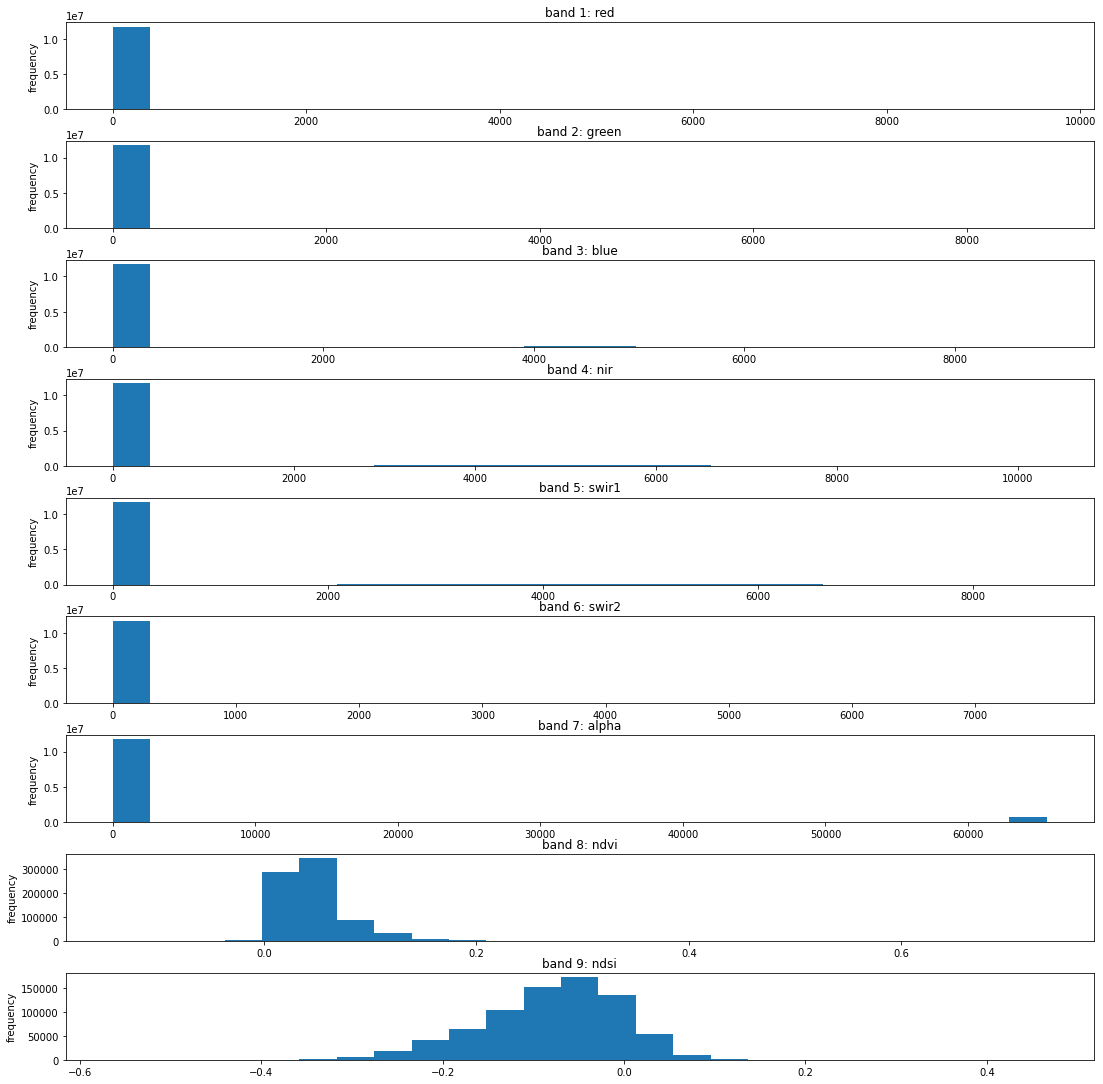

In [ ]:
'''creating histogram of values of images picked from aligned dataset'''

fig, axs = plt.subplots(np.shape(band_distribution)[1],1)

fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout()
bands = {0:'red',1:'green',2:'blue', 3:'nir', 4:'swir1', 5:'swir2', 6:'alpha', 7:'ndvi', 8:'ndsi'}

for i in range(np.shape(band_distribution)[1]):
  
  axs[i].hist(band_distribution[:,i].flatten().squeeze(),bins=25)
  
  axs[i].set_title("band " + str(i+1) + ": " + bands[i]) 
  axs[i].set_ylabel('frequency')


In [ ]:
def create_cloud_mask(img_array, blue_threshold):

  '''creating cloud mask from blue band (band 3) and swir band (band 5).
  blue band identifies dense clouds with high reflectance and 
  swir band differentiates snow from cloud because snow can have a high
  reflectance in blue band but low reflectance in swir1 band'''

  '''
  INPUTS:

  img_array (.tif as array): the .tif you want to apply a cloud mask on

  OUTPUTS:

  cloud_mask_matrix: matrix with zeros (invalid data) at the places where a cloud is predicted

  ''' 

  blue = np.where(img_array > blue_threshold)

  

  #finding where the points intersect between those that surpass the swir1 and blue

  df_blue = pd.DataFrame({'blue':[(blue[0][i],blue[1][i]) for i in range(len(blue[0]))]})
  
  #creating cloud mask matrix starting with an array of 1s (valid data), putting 0s where a cloud is predicted

  cloud_mask_matrix = np.ones((np.shape(img_array)[0], np.shape(img_array)[1])).astype('uint16')
  
  for i in df_blue['blue']:
    arr = np.array(i)
    cloud_mask_matrix[arr[0]][arr[1]] = 0
  return cloud_mask_matrix


In [ ]:
def rescale_img(img, min_val=0.0, max_val=1.0, dtype=np.float32, pmin=0.0, pmax=100.0):
    vmin, vmax = np.nanpercentile(img, pmin), np.nanpercentile(img, pmax)

    
    img_rescale = ((img - vmin) * (1.0 / (vmax - vmin) * max_val)).astype(dtype)
    np.clip(img_rescale, min_val, max_val, out=img_rescale)

    return img_rescale

#helper function to shorthand rescale_img with specific parameters

image_rescaled = lambda x: rescale_img(x,pmin = 0.2,pmax = 99.8)


def show_image(band, cloud_mask_arr, data_array, threshold, ground_truth_cloud_mask_arr):

  '''showing image with a comparison between original and cloud mask'''

  '''

  INPUTS:

  picture_num: (int) index of image stack loaded in (used to isolate individual images)
  band: (int) band of image to use e.g. band = 0 is the red band

  OUTPUTS:

  cloud_mask_picture : picture with cloud mask in specified band and threshold on blue band
  no_cloud_mask_picture : picture with no cloud mask in specified band
  ground_truth_cloud_mask_picture : picture with cloud mask in specified band and ground truth threshold on blue band (1250)


  '''

  
  alpha_band = (data_array[6].astype('bool')).astype('uint16') #edit this. i believe alpha band is band 7
  
  data_validation = cloud_mask_arr * alpha_band
  ground_truth_data_validation = ground_truth_cloud_mask_arr * alpha_band
 
  
  values, counts = np.unique(data_validation, return_counts = True)

  
  cloud_mask_picture = rescale_img(data_array[band]*(data_validation))
  no_cloud_mask_picture = rescale_img(data_array[band]*(alpha_band),pmin=0.2, pmax=99.8)
  ground_truth_cloud_mask_picture = rescale_img(data_array[band]*(ground_truth_data_validation))

  return cloud_mask_picture, no_cloud_mask_picture, ground_truth_cloud_mask_picture

  

  

In [ ]:
#extracting bands from toy dataset

blue_band = np.reshape(toy_dataset[:,2], (1,-1))
red_band = np.reshape(toy_dataset[:,0], (1,-1))
nir_band = np.reshape(toy_dataset[:,3], (1,-1))
ndvi_band = np.reshape(toy_dataset[:,7], (1,-1))
swir1_band = np.reshape(toy_dataset[:,4], (1,-1))
green_band = np.reshape(toy_dataset[:,1], (1,-1))
ndsi_band = np.reshape(toy_dataset[:,8], (1,-1))
sorted_blue_band = np.sort(blue_band)
blue_band_len = np.shape(blue_band)[1]

In [ ]:
blue_band = np.reshape(blue_band,(1,-1))

In [ ]:
#specifying threshold in which percentiles stop being 0

zero_threshold = (len(blue_band[blue_band == 0]) / len(blue_band[0])) *100

In [ ]:
zero_threshold

93.87387133760569

<h3><strong>Helper Functions <string></h3>

In [ ]:
def get_cloud_from_band(band,threshold,blue_band):
  '''
  extracts cloud pixels from band

  INPUTS:

  band : (array) array of values of the band
  threshold : (int) threshold on the blue band
  blue_band: (array) array of values of the blue band

  OUTPUTS:

  cloud : (array) pixels and their values belonging to the cloud surface

  '''
  cloud = band[0][np.where(blue_band[0] > threshold)]
  cloud = np.reshape(cloud, (-1,1))
  return cloud

def get_rvs_from_band(band,ndvi_band):
  '''
  extracts rvs pixels from band

  INPUTS:

  band : (array) array of values of the band
  ndvi_band: (array) array of values of the ndvi band

  OUTPUTS:

  rvs : (array) pixels and their values belonging to the rvs surface
  
  '''
  rvs = band[0][np.where(ndvi_band[0] >= 0)]
  rvs = np.reshape(rvs, (-1,1))
  return rvs

def create_z_cloud(bands,threshold,blue_band):
  length = len(np.where(blue_band[0] > threshold)[0])
  z_cloud = np.zeros((length,len(bands),1))
  for idx,band in enumerate(bands):
    cloud = get_cloud_from_band(band,threshold,blue_band)
    
    z_cloud[:,idx] = cloud
  z_cloud = np.nan_to_num(z_cloud, nan = 0)

  cloud_mean = np.nanmean(z_cloud,axis = 0)

  return z_cloud, cloud_mean

def create_z_rvs(bands,ndvi_band):
  length = len(np.where(ndvi_band[0] >= 0)[0])
  z_rvs = np.zeros((length,len(bands),1))
  for idx,band in enumerate(bands):
    rvs = get_rvs_from_band(band,ndvi_band)
    z_rvs[:,idx] = rvs
  z_rvs = np.nan_to_num(z_rvs, nan = 0)

  rvs_mean = np.nanmean(z_rvs, axis = 0)

  return z_rvs, rvs_mean

<h3><strong>Solver</strong></h3>

In [ ]:
#solver

#define thresholds

vals = [95,98,99]
thresholds = [np.percentile(blue_band,val) for val in vals]
thresholds.append(1250)

#define parameters

rbf_kernel = lambda x,y : np.matmul(x.T,y)

show_band = 0

ndvi_band = np.nan_to_num(ndvi_band, nan = -1) #dont want things to mistakenly be rvs
x_arr = []
dist_arr = []
bands = [blue_band, red_band, nir_band, green_band, swir1_band]
ground_truth_cloud_mask_arr = create_cloud_mask(reference_image_data[2], 1250) #blue band is first arg

arr = []
sign_counts = []

ground_truth_cloud_mask_arr = create_cloud_mask(reference_image_data[2], 1250)

#start process

for j in range(len(vals)+1):

  #instantiation
  print(j)
  threshold = thresholds[j]
  
  print(f'threshold : {threshold}')

  #create cloud mask
  
  cloud_mask_arr = create_cloud_mask(reference_image_data[2], threshold) #blue band is first arg
      
  x= []
  dist = []

  #cloud

  z_cloud, cloud_mean = create_z_cloud(bands, threshold, blue_band)

  #rock and vegetation

  #https://www.researchgate.net/publication/316471841_Quantification_and_understanding_the_observed_changes_in_land_cover_patterns_in_Bangalore/figures?lo=1
  
  z_rvs, rvs_mean = create_z_rvs(bands, ndvi_band)

  #formula - https://www.sciencedirect.com/science/article/abs/pii/S0034425717305138


  rbf_numerator = lambda x : rbf_kernel(x, cloud_mean) - rbf_kernel(x, rvs_mean) - rbf_kernel(cloud_mean, rvs_mean) + rbf_kernel(rvs_mean, rvs_mean)
  rbf_denominator_1 = lambda x : np.sqrt(rbf_kernel(x,x) - (2*rbf_kernel(x,rvs_mean)) + rbf_kernel(rvs_mean, rvs_mean))
  rbf_denominator_2 = lambda x : np.sqrt(rbf_kernel(cloud_mean,cloud_mean) - (2*rbf_kernel(cloud_mean,rvs_mean)) + rbf_kernel(rvs_mean, rvs_mean))
  cos_theta = lambda x : rbf_numerator(x) / (rbf_denominator_1(x) * rbf_denominator_2(x))
  for val in z_cloud:
    x.append(cos_theta(val))
    dist.append(rbf_kernel(val, rvs_mean))
     
  #evaluation

  values, counts = np.unique(np.sign(x), return_counts = True)
  try:
    sign_counts.append(abs(counts[1] - counts[0]))
  except:
    sign_counts.append(abs(counts[0]))
 
  cloud_mask_picture, no_cloud_mask_picture, ground_truth_cloud_mask_picture = show_image(show_band, cloud_mask_arr, reference_image_data, threshold, ground_truth_cloud_mask_arr)
  
  arr.append([cloud_mask_picture, no_cloud_mask_picture, ground_truth_cloud_mask_picture])
  
  x_arr.append(x)
  dist_arr.append(dist)





0
threshold : 2782.0
1
threshold : 4821.0
2
threshold : 5498.0
3
threshold : 1250


<h3><strong>Figures</strong></h3>

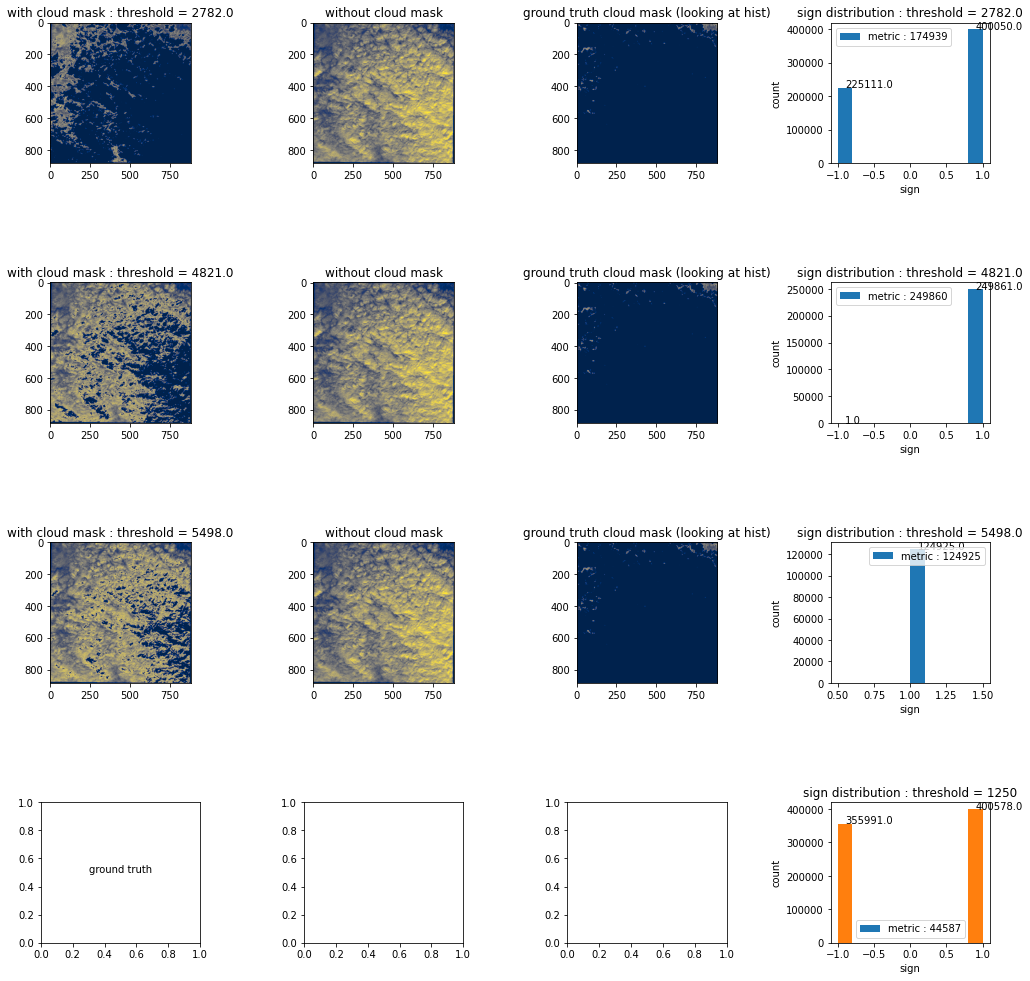

In [ ]:
fig, axs = plt.subplots(len(x_arr),4)
fig.tight_layout()

fig.set_figwidth(15)
fig.set_figheight(15)

for i in range(len(x_arr)-1):

  

  cloud_mask_picture = arr[i][0]
  no_cloud_mask_picture = arr[i][1]
  ground_truth_cloud_mask_picture = arr[i][2]

  #plots image with cloud mask

  axs[i,0].imshow(cloud_mask_picture, cmap = 'cividis')
  axs[i,0].set_title(f'with cloud mask : threshold = {thresholds[i]}')

  #plots image without cloud mask

  axs[i,1].imshow(no_cloud_mask_picture,cmap = 'cividis')
  axs[i,1].set_title('without cloud mask')

  #plots ground truth image

  axs[i,2].imshow(ground_truth_cloud_mask_picture,cmap = 'cividis')
  axs[i,2].set_title('ground truth cloud mask (looking at hist)')

  #plots histogram of sign dist

  _, _, patches = axs[i,3].hist(np.array(list(map(lambda x : np.sign(x), x_arr[i]))).flatten(), label = f'metric : {sign_counts[i]}')
  for pp in patches:
    x = (pp._x0 + pp._x1)/2
    y = pp._y1 + 0.05
    if(pp._y1>0):
      axs[i,3].text(x, y, pp._y1)

  axs[i,3].set_title(f'sign distribution : threshold = {thresholds[i]}')
  axs[i,3].set_xlabel('sign')
  axs[i,3].set_ylabel('count')
  axs[i,3].legend()

  

axs[len(x_arr)-1,0].text(0.3,0.5,'ground truth')

_, _, patches = axs[len(x_arr)-1,3].hist(np.array(list(map(lambda x : np.sign(x), x_arr[len(x_arr)-1]))).flatten(), label = f'metric : {sign_counts[len(x_arr)-1]}')
for pp in patches:
  x = (pp._x0 + pp._x1)/2
  y = pp._y1 + 0.05
  if(pp._y1>0):
    axs[len(x_arr)-1,3].text(x, y, pp._y1)

axs[len(x_arr)-1,3].hist(np.array(list(map(lambda x : np.sign(x), x_arr[len(x_arr)-1]))).flatten())
axs[len(x_arr)-1,3].set_title(f'sign distribution : threshold = {thresholds[len(x_arr)-1]}')
axs[len(x_arr)-1,3].set_xlabel('sign')
axs[len(x_arr)-1,3].set_ylabel('count')
axs[len(x_arr)-1,3].legend()





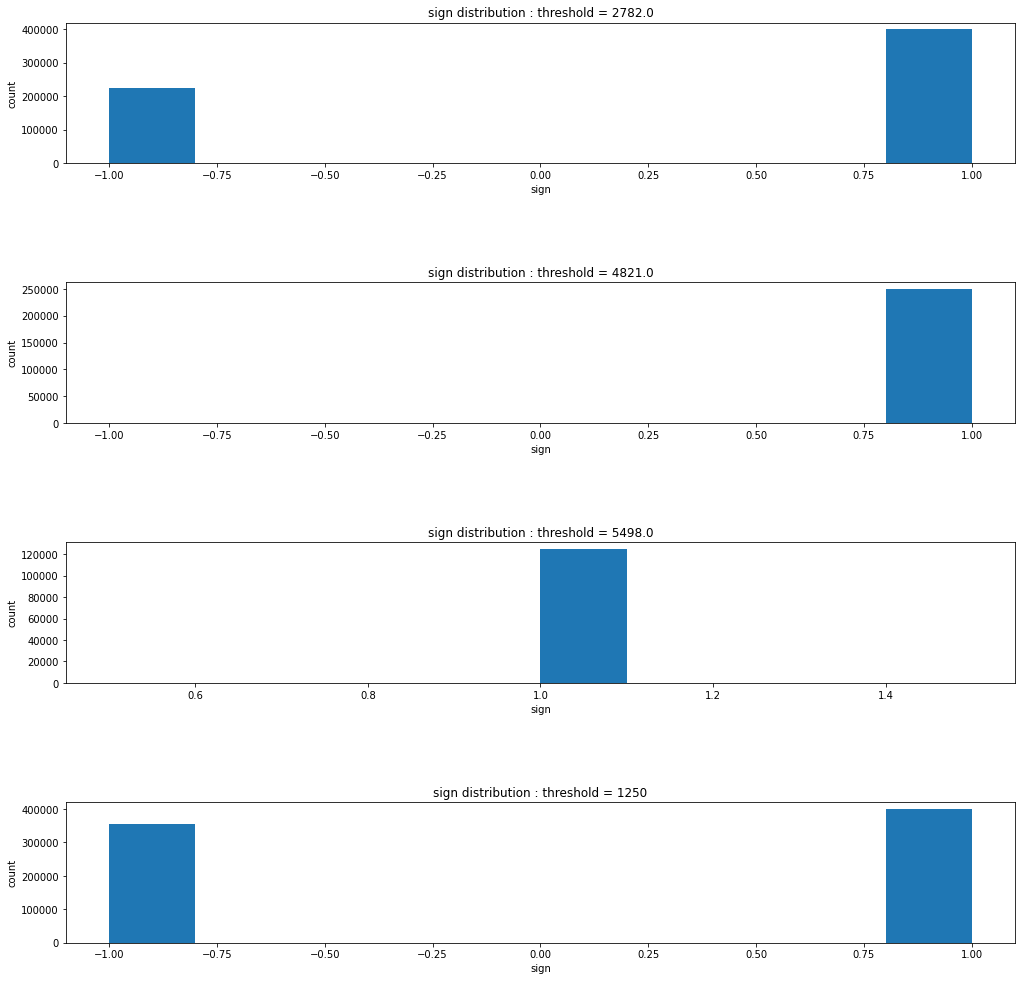

In [ ]:
fig, axs = plt.subplots(len(x_arr),1)
fig.tight_layout()

fig.set_figwidth(15)
fig.set_figheight(15)

for i in range(len(x_arr)):
  axs[i].hist(np.array(list(map(lambda x : np.sign(x), x_arr[i]))).flatten())
  axs[i].set_title(f'sign distribution : threshold = {thresholds[i]}')
  axs[i].set_xlabel('sign')
  axs[i].set_ylabel('count')

Text(0.5, 0.98, 'distance from rock and vegetation vs. theta rel for all thresholds')

/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


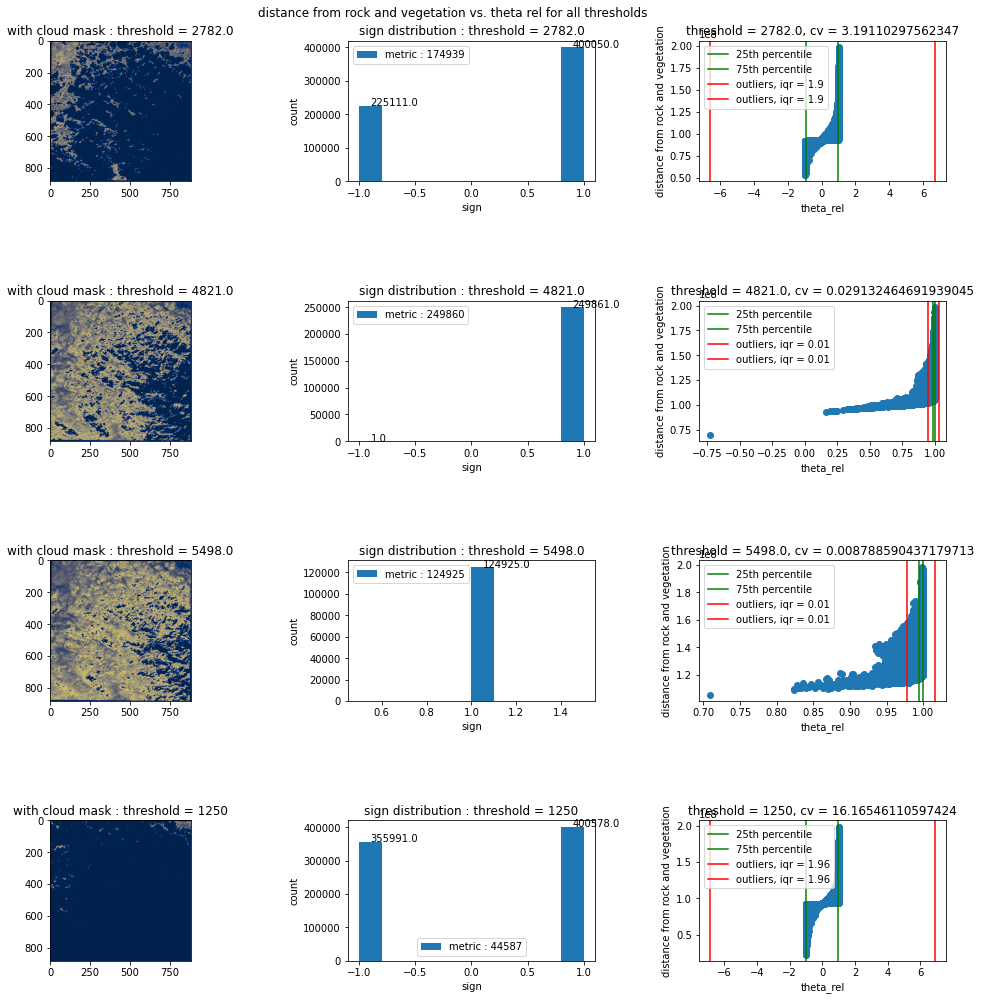

In [ ]:
from scipy.stats import iqr

fig, axs = plt.subplots(len(x_arr),3)
fig.tight_layout()

fig.set_figwidth(15)
fig.set_figheight(15)

cv = lambda x : np.std(x)/np.mean(x)

for i in range(len(x_arr)):

  cloud_mask_picture = arr[i][0]

  #image with cloud mask

  axs[i,0].imshow(cloud_mask_picture, cmap = 'cividis')
  axs[i,0].set_title(f'with cloud mask : threshold = {thresholds[i]}')
  
  #plots histogram of sign dist
  
  _, _, patches = axs[i,1].hist(np.array(list(map(lambda x : np.sign(x), x_arr[i]))).flatten(), label = f'metric : {sign_counts[i]}')
  for pp in patches:
    x = (pp._x0 + pp._x1)/2
    y = pp._y1 + 0.05
    if(pp._y1>0):
      axs[i,1].text(x, y, pp._y1)

  axs[i,1].set_title(f'sign distribution : threshold = {thresholds[i]}')
  axs[i,1].set_xlabel('sign')
  axs[i,1].set_ylabel('count')
  axs[i,1].legend()

  x_iqr = iqr(x_arr[i])

  #plots scatterplot of distribution
  
  axs[i,2].scatter(x_arr[i], dist_arr[i])
  pct_25 = np.percentile(x_arr[i],25)
  pct_75 = np.percentile(x_arr[i],75)
  axs[i,2].axvline(x = pct_25, color = 'g', label = '25th percentile')
  axs[i,2].axvline(x = pct_75, color = 'g', label = '75th percentile')
  axs[i,2].axvline(x = pct_75 + (3*x_iqr), color = 'r', label = f'outliers, iqr = {np.round(x_iqr,2)}')
  axs[i,2].axvline(x = pct_25 - (3*x_iqr), color = 'r', label = f'outliers, iqr = {np.round(x_iqr,2)}')
  
  axs[i,2].set_xlabel('theta_rel')
  axs[i,2].set_ylabel('distance from rock and vegetation')
  axs[i,2].set_title(f'threshold = {thresholds[i]}, cv = {cv(x_arr[i])}')
  axs[i,2].legend()

fig.suptitle('distance from rock and vegetation vs. theta rel for all thresholds')

In [ ]:
#print total time

total_time = time.time() - t0
print(total_time)

190.82920670509338
